In [ ]:
#TEXT CLUSTERING ANALYSIS
#TWO ALGOTIHMS: 1) SIMPLE BAG OF WORDS K-MEANS, 2)lATENT DIRICHLET ALLOCATION 
#DATA: THOMSON REUTERS TEXT RESEARCH COLLECTION "TRC2" (CORPUS OF 1,800,370 NEWS STORIES)

from time import time
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt
from nltk.stem.porter import  PorterStemmer
from scipy.spatial.distance import euclidean
from sklearn.decomposition import LatentDirichletAllocation

t0 = time()
df_text = pd.read_csv('./trc2.csv', error_bad_lines=False)
print("done in %0.3fs." % (time() - t0))


In [2]:
N_samples = 500000  #Number of samples used
df_text=df_text.dropna()
df_text=df_text.iloc[0:N_samples,:]
print(df_text.values.shape)
df = df_text
df.head()

(500000, 3)


,msg_dt,message,story_text
0,2008-01-01 00:00:03,Reuters Canadian dollar Eurobond new issue index,(Click on the Z-code in brackets to access dat...
1,2008-01-01 00:01:03,"DIARY - Government Debt auctions to March 27, ...","For other related diaries, please see; ..."
2,2008-01-01 00:01:05,Reuters Sports Features Schedule at 0001 GMT T...,The following sports feature is available:...
3,2008-01-01 00:01:05,"REITs hailed success, despite share price woes","By Jennifer Hill LONDON, Jan 1 (Reute..."
4,2008-01-01 00:01:07,Reuters sports schedule at 0001 GMT on Tuesday...,Jan 1 (Reuters) - Reuters sports schedule ...


In [3]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    return text

print('Preprocessor on Excerpt:%s' % preprocessor(df_text.loc[120, 'story_text'][-61:]))

porter = PorterStemmer()
def tokenizer_porter(text):
    return[porter.stem(word) for word in text.split()]

nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')


Preprocessor on Excerpt:l futuristic communications 961031 48 90 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df_text['message'] = df_text['message'].apply(preprocessor)
df_text['story_text'] = df_text['story_text'].apply(preprocessor)
X_text = (df_text['message'] + df_text['story_text']).values
X = df_text.iloc[:,1:3].values

In [5]:
#DOCUMENTS ARE FILTERED BY A WORD. IN THIS CASE HEADERS THAT CONTAIN "WAR"
X_word = []
lis = []
for i in range(0, N_samples-1, 1):
    X_tok =  tokenizer_porter(X[i, 0])
    for j in X_tok:
        if j == 'war':                                ##WORD FILTERING
            X_word = np.append(X_word, X_text[i])
            lis.append(i)
X_train = X_word

In [6]:
tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None, tokenizer=tokenizer_porter, stop_words=stop)
tok = tfidf.fit_transform(X_train)

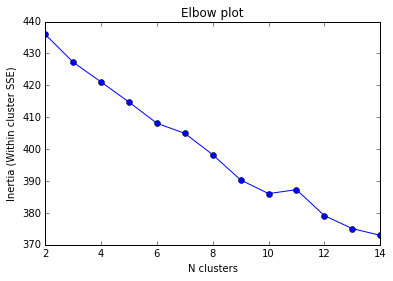

In [8]:
distortions = []
silh = []
for i in range(2, 15, 1):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    km.fit(tok)
    distortions.append(km.inertia_)
    silh.append(metrics.silhouette_score(tok, km.labels_, sample_size=1000))
    
plt.plot(range(2, 15, 1), distortions, marker='o')
plt.title('Elbow plot')
plt.xlabel('N clusters')
plt.ylabel('Inertia (Within cluster SSE)')

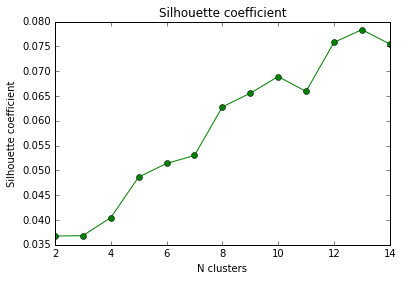

In [9]:
plt.plot(range(2, 15, 1), silh, marker='o',color='green')
plt.title('Silhouette coefficient')
plt.xlabel('N clusters')
plt.ylabel('Silhouette coefficient')

In [10]:
km = KMeans(n_clusters=12, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)
tok = tfidf.fit_transform(X_train)
y_km = km.fit_predict(tok)
np.bincount(y_km)

array([228,  19,  24,  38,  23,  22,  11,  13,  20,  52,  12,  15])

In [11]:
n_clusters=12
def top_headers(km, n_clusters, tok, y_km, lis):
    for j in range(0, n_clusters,1):
        cluster_0 = np.where(y_km==j) 
        X_cluster_0 = tok[cluster_0]
        distance= []
        for i in range(0, X_cluster_0.A.shape[0]):
            distance.append(euclidean(X_cluster_0.A[i], km.cluster_centers_[0]))    
        pos = np.argsort(distance)
        print 'Top 5 headers cluster %s: \n' % (j+1)
        for i in range(0,5,1):
            print df.iloc[np.asarray(lis)[cluster_0],1].iloc[pos[i]] 

        print '\n'
        
top_headers(km, n_clusters,tok,y_km,lis)

Top 5 headers cluster 1: 

analysis bush wins war over iraq war in washington
analysis bush wins war over iraq war in washington
factbox iraq war five years on in facts and figures
factbox iraq war five years on in facts and figures
u s war costs in iraq up budget report


Top 5 headers cluster 2: 

update 7 pressure eases on olmert after lebanon war report
update 5 israel inquiry finds grave failings on war
update 6 israel war inquiry gives pm qualified backing
update 2 allies rally to olmert before war report
update 8 pressure off olmert after lebanon war report


Top 5 headers cluster 3: 

refile update 3 toshiba to quit hd dvds ends format war
analysis sony wins format war but real battle lies ahead
update 2 toshiba says to quit hd dvd ending format war
update 3 toshiba to quit hd dvds ends format war
update 4 looming end to dvd war cheers consumers investors


Top 5 headers cluster 4: 

sri lanka jets bomb rebels no end to war in sight
interview food oil price rises worse than s l

In [32]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
n_top_words = 20

lda = LatentDirichletAllocation(n_topics=12, max_iter=40, learning_method='online', learning_offset=100.,
                                random_state=0)
lda.fit(tok)

tf_feature_names = tfidf.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0:
iraq dvd id war bulldoz uncc warinc ntt perish american idea mccain smith budapest revolt thi hari said u us
Topic #1:
dvd blu ray hd toshiba id format soni technolog corp inc player warner sale definit studio disc stxnew electron lawson
Topic #2:
acr ang atmospher poison diseas ethnic colombia apiec hunger lat dope chalmer cleric colombian senecan gould nsp129226 gump 2bct sew
Topic #3:
farmer margin mugab 260 aden russia fitna 21st vener commun expir logjam eastern liabil zimbabwean russian migrant repriev state bibl
Topic #4:
significantli stand sadr ks margin smoothest drag mapenzauswa polisario air earn embezzl u elud mcconnel period magazin link ga hayaniya
Topic #5:
iraq war bush petraeu said u hi olmert reuter wa democrat kosovo sadr iran ha minist prime militari former mccain
Topic #6:
241 industri para well twitto shrapnel comparison commend oakland granddaught ahsoka pervez extrajudici ultra trick mekel cite schedul craig egypt
Topic #7:
said rebel blu kill war dvd